In [ ]:
import pandas as pd

# Load processed dataset with Sentiment Score and Dominant_Topic
df = pd.read_csv("../data/processed/topic_labeled_tickets.csv")

# Drop irrelevant or high-cardinality text columns
drop_cols = [
    "Ticket ID", "Customer Name", "Customer Email", "Ticket Subject",
    "Ticket Description", "Resolution", "Cleaned_Description"
]

# Drop columns only if they exist
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# One-hot encode categorical columns
df = pd.get_dummies(df, drop_first=True)

# Drop rows with missing target
df = df.dropna(subset=["Customer Satisfaction Rating"])

# Define feature matrix X and target y
X = df.drop("Customer Satisfaction Rating", axis=1)
y = df["Customer Satisfaction Rating"]

print(" Data ready for modeling. Shape of X:", X.shape)


 Data ready for modeling. Shape of X: (2769, 16856)


# Model Training

In [7]:
#  Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

#  Load the data
df = pd.read_csv("../data/processed/topic_labeled_tickets.csv")

#  Drop unnecessary columns
drop_cols = [
    "Ticket ID", "Customer Name", "Customer Email", "Ticket Subject",
    "Ticket Description", "Resolution", "Cleaned_Description", "Date of Purchase"
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

#  Drop rows with missing target
df.dropna(subset=["Customer Satisfaction Rating"], inplace=True)

#  Encode categorical variables
cat_cols = df.select_dtypes(include="object").columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # Save for inverse-transform if needed

#  Train-test split
X = df.drop("Customer Satisfaction Rating", axis=1)
y = df["Customer Satisfaction Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)
print( "Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         1.0       0.19      0.22      0.21       109
         2.0       0.15      0.14      0.14       117
         3.0       0.26      0.30      0.28       112
         4.0       0.23      0.21      0.22       108
         5.0       0.20      0.17      0.18       108

    accuracy                           0.21       554
   macro avg       0.21      0.21      0.21       554
weighted avg       0.21      0.21      0.21       554

 Confusion Matrix:
 [[24 25 26 17 17]
 [35 16 29 19 18]
 [23 16 34 22 17]
 [21 25 17 23 22]
 [22 26 25 17 18]]


# SHAP

In [16]:
type(shap_values)  
len(shap_values) 


554

In [17]:
print(type(shap_values))     # List?
print(len(shap_values))      # Should be 2 for binary
print(type(shap_values[0]))  # Should be shap.Explanation
print(shap_values[0].values.shape)


<class 'shap._explanation.Explanation'>
554
<class 'shap._explanation.Explanation'>
(13, 5)


In [19]:
print(model.classes_)


[1. 2. 3. 4. 5.]


In [25]:
print("SHAP values shape:", class_shap.values.shape)
print("SHAP data shape:", class_shap.data.shape)



SHAP values shape: (13, 5)
SHAP data shape: (13,)


100%|===================| 2764/2770 [02:57<00:00]        

SHAP values shape: (554, 13, 5)


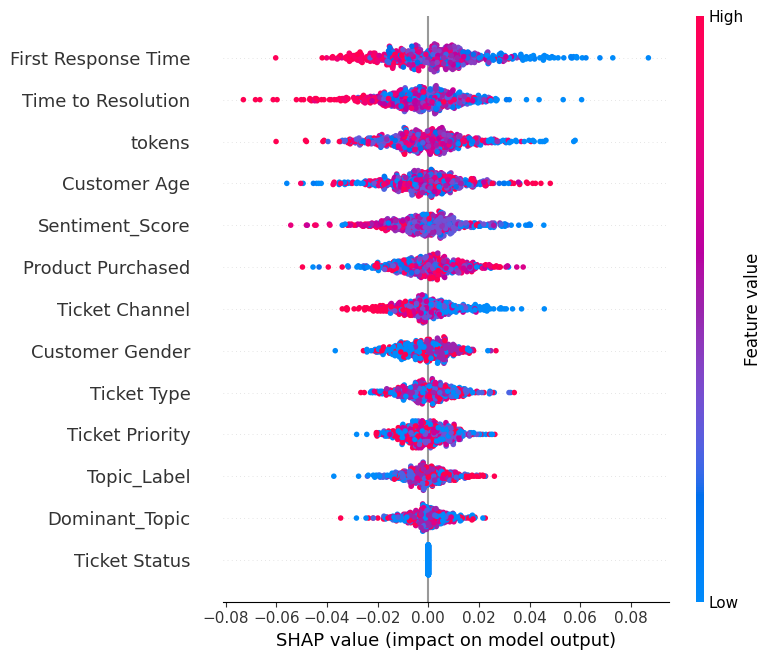

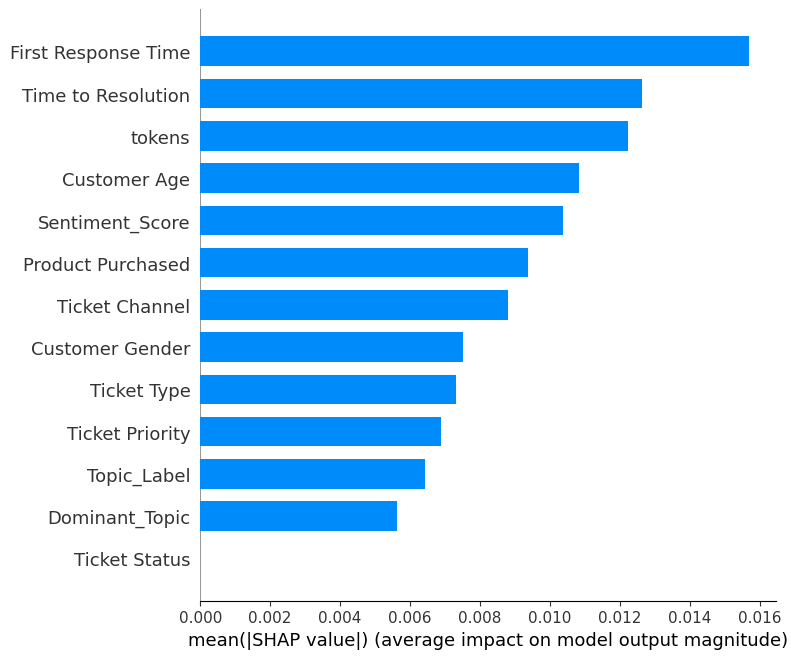

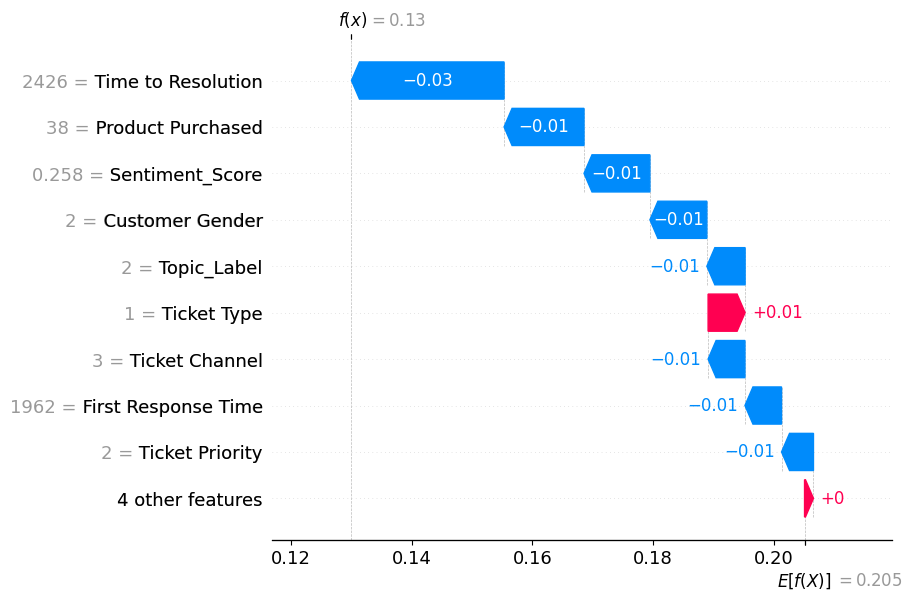

In [ ]:
import shap
import matplotlib.pyplot as plt

# Rebuild explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values (single Explanation with shape [n_samples, n_features, n_classes])
shap_values = explainer(X_test, check_additivity=False)

# Confirm the shape
print("SHAP values shape:", shap_values.values.shape)  # e.g., (554, 13, 5)

# Pick class index (e.g., 4 for class label 5.0)
class_idx = 4

# Extract SHAP values for class 5
class_shap = shap.Explanation(
    values=shap_values.values[:, :, class_idx],
    base_values=shap_values.base_values[:, class_idx],
    data=shap_values.data,
    feature_names=X_test.columns.tolist()
)

#  Summary plot (beeswarm)
shap.summary_plot(class_shap, X_test)

#  Global importance bar plot
shap.summary_plot(class_shap, X_test, plot_type="bar")

#  Waterfall for one instance
shap.plots.waterfall(class_shap[0])
